In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os
import sys
sys.path.append('/u/dbeaglehole/mech_interp/neural_controllers/')

from neural_controllers import NeuralController
from utils import load_model

## Llama 3.1 8B

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['pca', 'rfm', 'linear', 'logistic']

# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

hal_type = 'general'
# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../halu_eval_results/llama_3_8b_it_{method}_seed_{s}_{hal_type}_val_metrics.pkl'
        path_test = f'../halu_eval_results/llama_3_8b_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nSingle best layer:")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Single best layer:

PCA:
acc: 80.0710 ± 0.4673
precision: 0.8101 ± 0.0217
recall: 0.5147 ± 0.0183
f1: 0.6290 ± 0.0110

RFM:
acc: 82.0319 ± 0.2929
precision: 0.8483 ± 0.0137
recall: 0.5516 ± 0.0047
f1: 0.6685 ± 0.0071

LINEAR:
acc: 78.6335 ± 0.1976
precision: 0.7507 ± 0.0056
recall: 0.5234 ± 0.0138
f1: 0.6166 ± 0.0081

LOGISTIC:
acc: 70.9139 ± 0.5595
precision: 0.8451 ± 0.0228
recall: 0.1409 ± 0.0108
f1: 0.2412 ± 0.0148


In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../halu_eval_results/llama_3_8b_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAggregated Over layers:")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


Aggregated Over layers:

LINEAR:
acc: 84.0284 ± 0.3549
precision: 0.8750 ± 0.0087
recall: 0.5994 ± 0.0073
f1: 0.7114 ± 0.0076

RFM:
acc: 83.7445 ± 0.1698
precision: 0.8283 ± 0.0146
recall: 0.6376 ± 0.0095
f1: 0.7204 ± 0.0042

LOGISTIC:
acc: 81.0736 ± 0.2358
precision: 0.9225 ± 0.0108
recall: 0.4628 ± 0.0054
f1: 0.6163 ± 0.0040

RFM_LINEAR:
acc: 84.5608 ± 0.4916
precision: 0.8876 ± 0.0163
recall: 0.6066 ± 0.0092
f1: 0.7207 ± 0.0116

LINEAR_RFM:
acc: 83.5049 ± 0.3142
precision: 0.8319 ± 0.0161
recall: 0.6239 ± 0.0050
f1: 0.7130 ± 0.0078

TRIVIAL ACCURACY: 67.1517 ± 0.4717


## Gemma 2 9b

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['pca', 'rfm', 'linear', 'logistic']

# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

hal_type = 'general'
# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../halu_eval_results/gemma_2_9b_it_{method}_seed_{s}_{hal_type}_val_metrics.pkl'
        path_test = f'../halu_eval_results/gemma_2_9b_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 83.0524 ± 0.2691
precision: 0.8773 ± 0.0074
recall: 0.5626 ± 0.0103
f1: 0.6855 ± 0.0092

RFM:
acc: 82.9547 ± 0.1716
precision: 0.8895 ± 0.0056
recall: 0.5494 ± 0.0094
f1: 0.6791 ± 0.0060

LINEAR:
acc: 79.0949 ± 0.1101
precision: 0.7210 ± 0.0068
recall: 0.5928 ± 0.0086
f1: 0.6506 ± 0.0069

LOGISTIC:
acc: 72.5732 ± 0.6239
precision: 0.8569 ± 0.0495
recall: 0.2006 ± 0.0237
f1: 0.3238 ± 0.0277


In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../halu_eval_results/gemma_2_9b_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 83.4161 ± 0.4782
precision: 0.8760 ± 0.0166
recall: 0.5767 ± 0.0107
f1: 0.6954 ± 0.0116

RFM:
acc: 82.7862 ± 0.5612
precision: 0.7912 ± 0.0241
recall: 0.6475 ± 0.0087
f1: 0.7119 ± 0.0090

LOGISTIC:
acc: 81.0382 ± 0.5358
precision: 0.8798 ± 0.0217
recall: 0.4896 ± 0.0129
f1: 0.6290 ± 0.0136

RFM_LINEAR:
acc: 84.9778 ± 0.2148
precision: 0.9262 ± 0.0144
recall: 0.5897 ± 0.0009
f1: 0.7206 ± 0.0041

LINEAR_RFM:
acc: 81.7658 ± 0.4027
precision: 0.7771 ± 0.0184
recall: 0.6245 ± 0.0088
f1: 0.6923 ± 0.0055

TRIVIAL ACCURACY: 67.1517 ± 0.4717


## Judge models

In [12]:

seeds = np.arange(5)
hal_type = 'qa'

# Dictionary to store accumulated metrics
accumulated_metrics = {}
# Iterate over seeds
for seed in seeds:
    with open(f'/u/dbeaglehole/mech_interp/neural_control_dev/quantitative_comparisons/halu_eval_results/llama_gpt-4o_seed_{seed}_{hal_type}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('Llama (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


Llama (averaged over seeds)
------------------------------
acc: 60.0250 ± 0.6731
precision: 0.6468 ± 0.0096
recall: 0.4412 ± 0.0080
f1: 0.5245 ± 0.0075
trivial_acc: 50.5779 ± 0.1738


In [13]:
# Dictionary to store accumulated metrics
accumulated_metrics = {}
# Iterate over seeds
for seed in seeds:
    with open(f'/u/dbeaglehole/mech_interp/neural_control_dev/quantitative_comparisons/halu_eval_results/openai_gpt-4o_seed_{seed}_{hal_type}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('GPT-4o (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


GPT-4o (averaged over seeds)
------------------------------
acc: 65.2389 ± 0.4677
precision: 0.6460 ± 0.0065
recall: 0.6740 ± 0.0058
f1: 0.6596 ± 0.0039
trivial_acc: 50.5779 ± 0.1738


## Gemma

In [18]:
# Dictionary to store accumulated metrics
accumulated_metrics = {}
# Iterate over seeds
for seed in seeds:
    with open(f'../halu_eval_results/gemma_gpt-4o_seed_{seed}_{hal_type}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('Gemma (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

Gemma (averaged over seeds)
------------------------------
acc: 65.5546 ± 0.3351
precision: 0.3779 ± 0.0354
recall: 0.0766 ± 0.0106
f1: 0.1273 ± 0.0166
trivial_acc: 67.1517 ± 0.4717


### Layer-wise plots

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, 'linear_agg'])
layers [-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


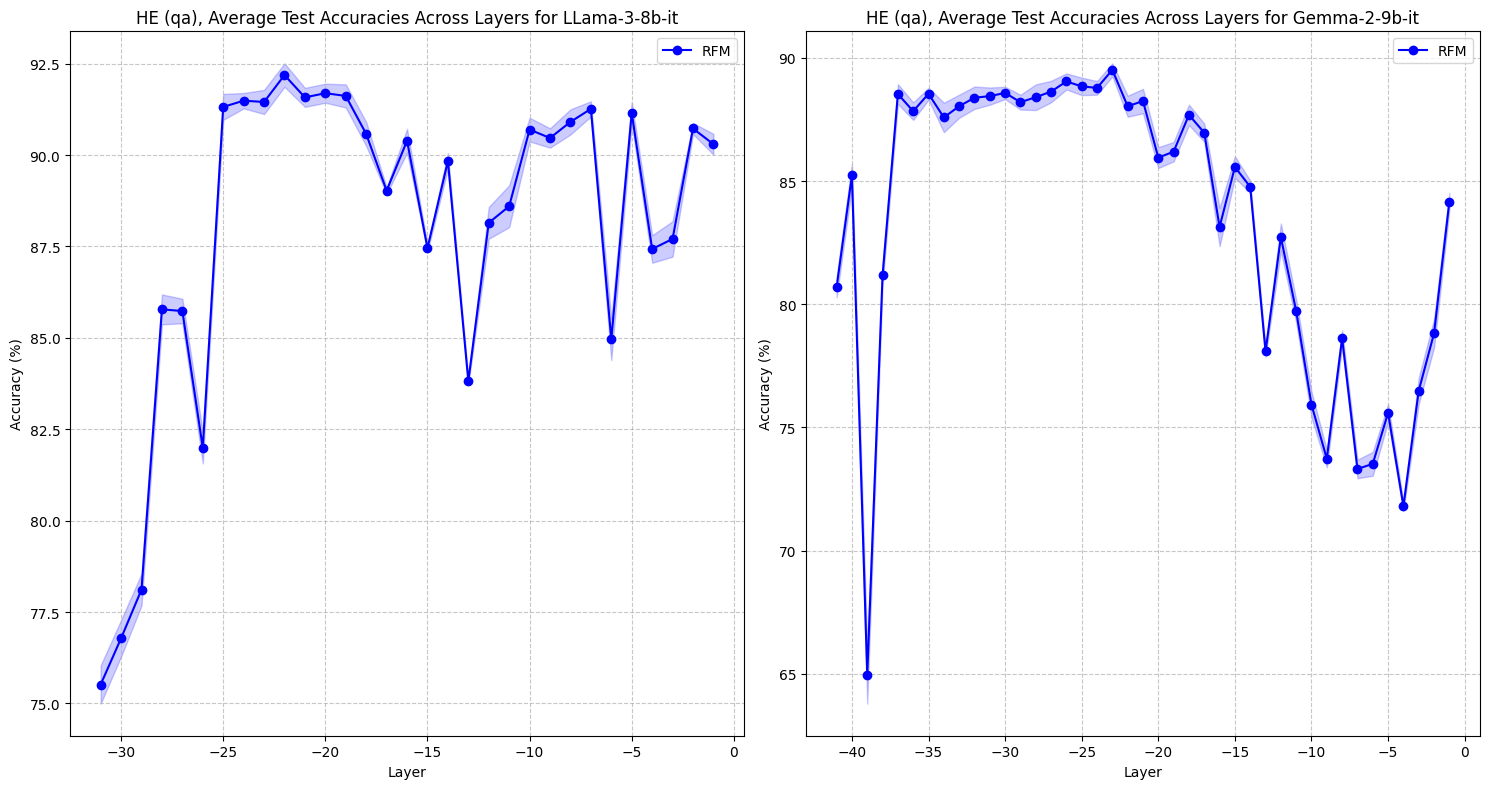

In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm']#, 'logistic']
models = ['llama_3_8b', 'gemma_2_9b']

# Initialize dictionaries to store results
all_results = {}
hal_type = 'qa'
for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'/u/dbeaglehole/mech_interp/neural_controllers/quantitative_comparisons/halu_eval_results/{model}_it_{method}_seed_{s}_{hal_type}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key]['acc'])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'HE ({hal_type}), Average Test Accuracies Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig(f'he_{hal_type}_test_accuracies_across_layers.pdf', format='pdf')
plt.show()